# Load data

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

In [1]:
import sage
from sklearn.model_selection import train_test_split

In [2]:
# Load data
df = sage.datasets.bank()

# Feature names and categorical columns (for CatBoost model)
feature_names = df.columns.tolist()[:-1]
categorical_cols = ['Job', 'Marital', 'Education', 'Default', 'Housing',
                    'Loan', 'Contact', 'Month', 'Prev Outcome']
categorical_inds = [feature_names.index(col) for col in categorical_cols]

In [3]:
# Split data
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=123)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=123)
Y_train = train[:, -1].copy().astype(int)
Y_val = val[:, -1].copy().astype(int)
Y_test = test[:, -1].copy().astype(int)
train = train[:, :-1].copy()
val = val[:, :-1].copy()
test = test[:, :-1].copy()

# Train model

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from catboost import CatBoostClassifier

In [5]:
model = CatBoostClassifier(iterations=100,
                           learning_rate=0.3,
                           depth=10)

model = model.fit(train, Y_train, categorical_inds, eval_set=(val, Y_val),
                  verbose=False)

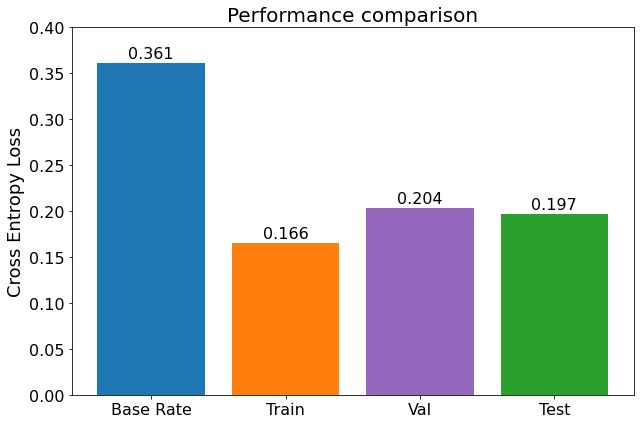

In [6]:
# Calculate performance
p = np.array([np.sum(Y_train == i) for i in np.unique(Y_train)]) / len(Y_train)
base_ce = log_loss(Y_test, p[np.newaxis].repeat(len(test), 0))
train_ce = log_loss(Y_train, model.predict_proba(train))
val_ce = log_loss(Y_val, model.predict_proba(val))
test_ce = log_loss(Y_test, model.predict_proba(test))

# Plot
plt.figure(figsize=(9, 6))
plt.bar(np.arange(4), [base_ce, train_ce, val_ce, test_ce],
        color=['tab:blue', 'tab:orange', 'tab:purple', 'tab:green'])

ax = plt.gca()
for i, ce in enumerate([base_ce, train_ce, val_ce, test_ce]):
    ax.text(i - 0.17, ce + 0.005, '{:.3f}'.format(ce), fontsize=16)
    
plt.ylim(0, 0.4)

plt.xticks(np.arange(4), ['Base Rate', 'Train', 'Val', 'Test'])
plt.tick_params(labelsize=16)
plt.ylabel('Cross Entropy Loss', fontsize=18)
plt.title('Performance comparison', fontsize=20)

plt.tight_layout()
plt.show()

# Calculate importance for train, val, test

- Among the three splits, the SAGE values are roughly the same

In [7]:
# Setup and calculate
imputer = sage.MarginalImputer(model, train[:512])
estimator = sage.KernelEstimator(imputer, 'cross entropy')
sage_train = estimator(train, Y_train, thresh=0.025)
sage_val = estimator(val, Y_val, thresh=0.025)
sage_test = estimator(test, Y_test, thresh=0.025)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

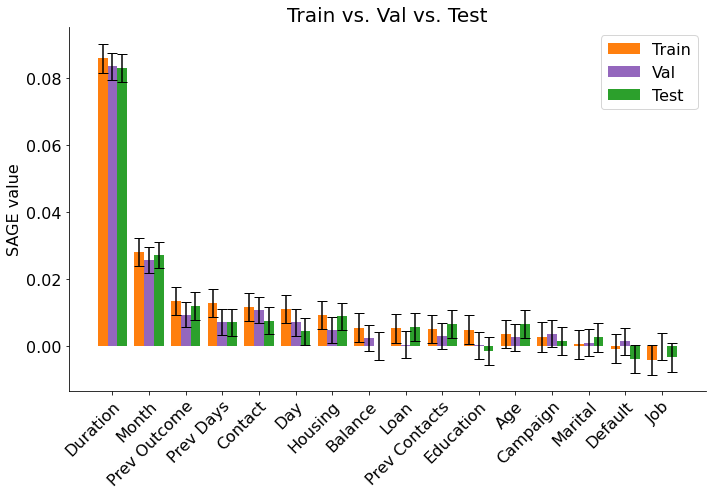

In [8]:
sage.comparison_plot((sage_train, sage_val, sage_test),
                     ('Train', 'Val', 'Test'),
                     feature_names,
                     colors=('tab:orange', 'tab:purple', 'tab:green'),
                     title='Train vs. Val vs. Test')

# Compare to datasets with covariate shift

- We can introduce covariate shifts by modifying individual features (e.g., how call durations are encoded)
- The covariate shift wrecks the model's performance, sometimes even making it worse than the base rate performance

In [9]:
# Convert duration to seconds
test_seconds = test.copy()
duration_index = feature_names.index('Duration')
test_seconds[:, duration_index] = test_seconds[:, duration_index] * 60

# Convert duration to hours
test_hours = test.copy()
test_hours[:, duration_index] = test_hours[:, duration_index] / 60

# Shift months by one
test_month = test.copy()
month_index = feature_names.index('Month')
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
          'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
test_month[:, month_index] = list(
    map(lambda x: months[(months.index(x) + 1) % 12],
        test_month[:, month_index]))

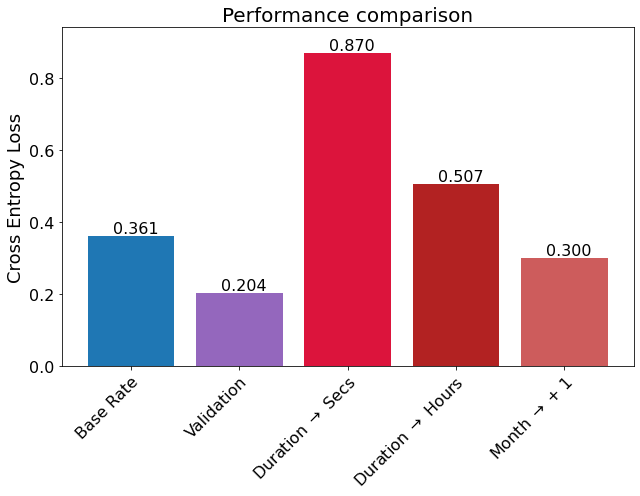

In [10]:
# Calculate performance
p = np.array([np.sum(Y_train == i) for i in np.unique(Y_train)]) / len(Y_train)
base_ce = log_loss(Y_test, p[np.newaxis].repeat(len(test), 0))
val_ce = log_loss(Y_val, model.predict_proba(val))
seconds_ce = log_loss(Y_test, model.predict_proba(test_seconds))
hours_ce = log_loss(Y_test, model.predict_proba(test_hours))
month_ce = log_loss(Y_test, model.predict_proba(test_month))

# Plot
plt.figure(figsize=(9, 7))
plt.bar(np.arange(5), [base_ce, val_ce, seconds_ce, hours_ce, month_ce],
        color=['tab:blue', 'tab:purple', 'crimson', 'firebrick', 'indianred'])

ax = plt.gca()
for i, ce in enumerate([base_ce, val_ce, seconds_ce, hours_ce, month_ce]):
    ax.text(i - 0.17, ce + 0.007, '{:.3f}'.format(ce), fontsize=16)
    
plt.ylim(0, 0.94)

plt.xticks(np.arange(5),
           ['Base Rate', 'Validation', r'Duration $\rightarrow$ Secs',
            r'Duration $\rightarrow$ Hours', r'Month $\rightarrow$ + 1'],
           rotation=45, rotation_mode='anchor', ha='right')
plt.tick_params(labelsize=16)
plt.ylabel('Cross Entropy Loss', fontsize=18)
plt.title('Performance comparison', fontsize=20)

plt.tight_layout()
plt.show()

# Use SAGE to identify features that hurt performance

- SignEstimator calculates SAGE values to a lower precision, focusing on the sign (whether they help or hurt)

In [11]:
# Calculate feature importance for perturbed data
imputer = sage.MarginalImputer(model, val[:512])
estimator = sage.SignEstimator(imputer, 'cross entropy')
sage_seconds = estimator(test_seconds, Y_test)
sage_hours = estimator(test_hours, Y_test)
sage_month = estimator(test_month, Y_test)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

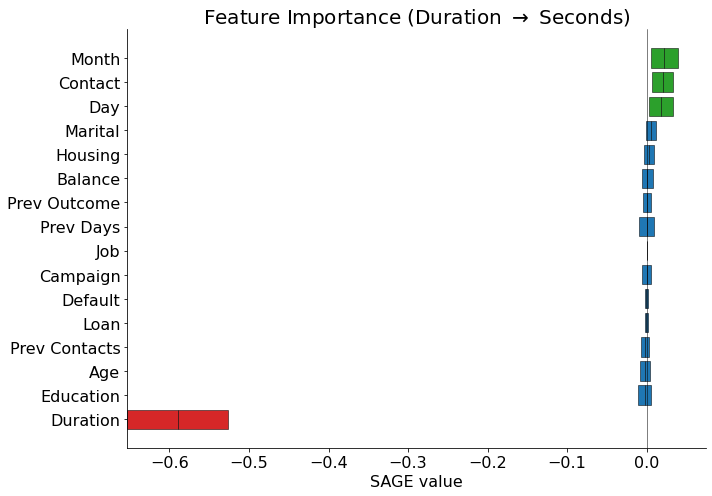

In [12]:
sage_seconds.plot_sign(feature_names, title=r'Feature Importance (Duration $\rightarrow$ Seconds)')

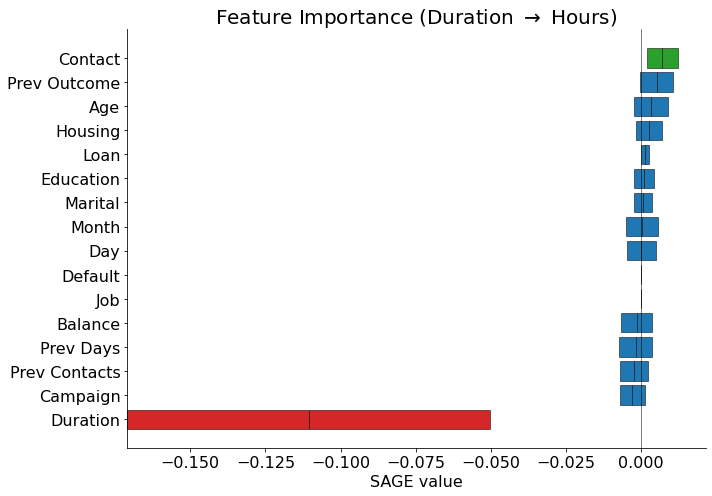

In [13]:
sage_hours.plot_sign(feature_names, title=r'Feature Importance (Duration $\rightarrow$ Hours)')

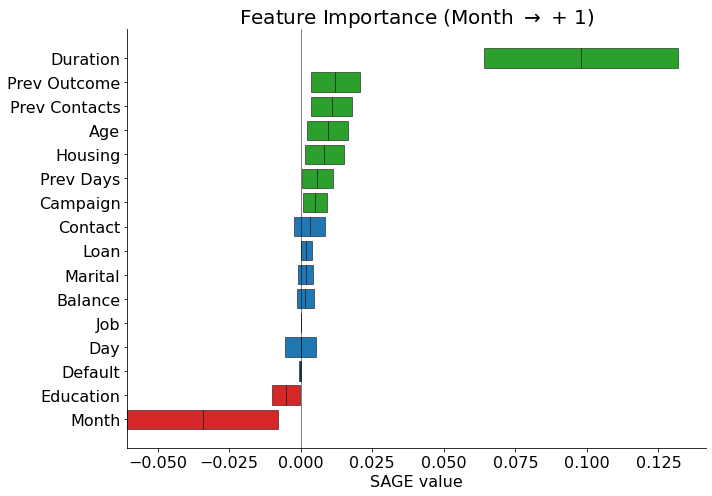

In [14]:
sage_month.plot_sign(feature_names, title=r'Feature Importance (Month $\rightarrow$ + 1)')